## Sentiment analysis on messages using modified SentiCR

#### Among the various classifiers tried, XGBoost and GradientBoostingClassifier performed best with accuracies ~0.86
#### Currently sentiment labels are being predicted: -1 -Negative, 0 -Neutral, 1 -Positive

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
from numpy import save, load
import sqlalchemy as s
import unicodedata
import time
from sqlalchemy import create_engine

# Importing SentiCR
from Sentiment import SentiCR
# Perform training or use trained model if exists. 
sentiment_analyzer = SentiCR(algo = 'XGB' )


Using TensorFlow backend.


Using existing trained Model


In [2]:
# Connection to local Postgres database

In [3]:
repo_id = 25774

# Fetch PR and issue messages of repo_id
join_SQL = s.sql.text("""
       select message.msg_id, msg_timestamp,  msg_text from augur_data.message
left outer join augur_data.pull_request_message_ref on message.msg_id = pull_request_message_ref.msg_id 
left outer join augur_data.pull_requests on pull_request_message_ref.pull_request_id = pull_requests.pull_request_id
where repo_id = :repo_id
UNION
select message.msg_id, msg_timestamp, msg_text from augur_data.message
left outer join augur_data.issue_message_ref on message.msg_id = issue_message_ref.msg_id 
left outer join augur_data.issues on issue_message_ref.issue_id = issues.issue_id
where repo_id = :repo_id
""")

# Transfer to Pandas df
df_message = pd.read_sql_query(join_SQL, engine, params={'repo_id': repo_id})

In [4]:
df_message

,msg_id,msg_timestamp,msg_text
0,1732709,2014-03-10 21:20:54,"Hi Artem, can you take another pass over this ..."
1,1734278,2014-05-01 17:01:48,Found one thing I want to change before review...
2,1728841,2013-09-23 15:18:57,We probably need to look into some options to ...
3,1727849,2013-08-12 17:35:10,Merged after review and testing. The tab compl...
4,1731943,2014-01-28 14:13:52,"> Also, looking at JobsController, those are n..."
...,...,...,...
4417,1742283,2015-04-24 23:15:38,"LGTM, rebased and merged into master 8a40e9d22..."
4418,1740237,2015-01-14 15:21:06,LGTM Starting Acceptance Test Pass.\n
4419,1726954,2013-07-23 17:52:57,I meant that your solution does modules->dirt....
4420,1736136,2014-06-23 18:10:57,Good catch. LGTM; merging.\n


### Get predicted sentiment labels

In [15]:
# Function to get sentiment score
def get_senti_score(df,col,label=False):
    start_time = time.time()
    siz = df.shape[0]
    i = 0
    labels = []
    scores = []
    while (i<siz):
        if label:
            x, y = sentiment_analyzer.get_sentiment_polarity(df.iloc[i][col],label)
            labels.append(x)
            scores.append(y)
        else:
            score = sentiment_analyzer.get_sentiment_polarity(df.iloc[i][col],label)
            scores.append(score)
        i+=1
    scores = np.array(scores)
    labels = np.array(labels)
    print("--- %s seconds ---" % (time.time() - start_time))
    if label:
        return (labels,scores)
    return scores

In [28]:
# Getting senti score on our data
df_message['senti_label'], df_message['senti_score'] = get_senti_score(df_message,'msg_text',label=True)

--- 27.242948055267334 seconds ---


In [16]:
# Getting scores on custom test set
df_test = pd.read_csv('mod_test.csv')
df_test['pred_senti_label'],df_test['pred_senti_score'] = get_senti_score(df_test,'Text',label=True)

--- 1.553969144821167 seconds ---


### Evaluating on custom test set

In [17]:
# Results using XGB as classifier

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_test['score'], df_test['pred_senti_label'])
print('Accuracy: '+str(accuracy))

Accuracy: 0.8674463937621832


In [18]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(df_test['score'], df_test['pred_senti_label'])
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[146  20   2]
 [ 12 110   8]
 [  9  17 189]]


In [19]:
df_test.groupby('score').count()

,Text,pred_senti_label,pred_senti_score
score,,,
-1,168,168,168
0,130,130,130
1,215,215,215


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(df_test['score'], df_test['pred_senti_label'])))

print('Micro Precision: {:.2f}'.format(precision_score(df_test['score'], df_test['pred_senti_label'], average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(df_test['score'], df_test['pred_senti_label'], average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(df_test['score'], df_test['pred_senti_label'], average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(df_test['score'], df_test['pred_senti_label'], average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(df_test['score'], df_test['pred_senti_label'], average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(df_test['score'], df_test['pred_senti_label'], average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(df_test['score'], df_test['pred_senti_label'], average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(df_test['score'], df_test['pred_senti_label'], average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(df_test['score'], df_test['pred_senti_label'], average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(df_test['score'], df_test['pred_senti_label'], target_names=['Negative', 'Neutral', 'Positive']))


Accuracy: 0.87

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.86
Macro Recall: 0.86
Macro F1-score: 0.86

Weighted Precision: 0.87
Weighted Recall: 0.87
Weighted F1-score: 0.87

Classification Report

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87       168
     Neutral       0.75      0.85      0.79       130
    Positive       0.95      0.88      0.91       215

    accuracy                           0.87       513
   macro avg       0.86      0.86      0.86       513
weighted avg       0.87      0.87      0.87       513



In [30]:
df_message.to_csv(f'senti_repo_{repo_id}.csv', index=False)

In [29]:
df_message

,msg_id,msg_timestamp,msg_text,senti_score,senti_label
0,1732709,2014-03-10 21:20:54,"Hi Artem, can you take another pass over this ...",0.996416,1.0
1,1734278,2014-05-01 17:01:48,Found one thing I want to change before review...,0.000000,0.0
2,1728841,2013-09-23 15:18:57,We probably need to look into some options to ...,0.000000,0.0
3,1727849,2013-08-12 17:35:10,Merged after review and testing. The tab compl...,0.999787,1.0
4,1731943,2014-01-28 14:13:52,"> Also, looking at JobsController, those are n...",0.000000,0.0
...,...,...,...,...,...
4417,1742283,2015-04-24 23:15:38,"LGTM, rebased and merged into master 8a40e9d22...",0.687396,1.0
4418,1740237,2015-01-14 15:21:06,LGTM Starting Acceptance Test Pass.\n,0.981673,1.0
4419,1726954,2013-07-23 17:52:57,I meant that your solution does modules->dirt....,0.000000,0.0
4420,1736136,2014-06-23 18:10:57,Good catch. LGTM; merging.\n,0.995173,1.0


### Proceed to timeseries analysis using sentiment trends

In [31]:
df = df_message.copy()
df['date'] =  pd.to_datetime(df["msg_timestamp"])
df = df.drop(['msg_timestamp'],axis=1)

In [32]:
df['date'].nunique()

4421

### 1. Grouping sentiments weekly for visualization

In [33]:
df = df.sort_values(by='date')
df1 = df.groupby(pd.Grouper(key='date', freq="w"))['senti_label'].value_counts().unstack()

In [35]:
df1 = df1.fillna(0)
df1['total'] = df1.sum(axis=1)
df1.columns = ['Negative','Neutral','Positive','Total']
df1 = df1[df1['Positive']+df1['Negative']!=0]

In [36]:
df1

,Negative,Neutral,Positive,Total
date,,,,
2013-05-05,0.0,0.0,1.0,1.0
2013-05-19,1.0,0.0,0.0,1.0
2013-05-26,0.0,1.0,1.0,2.0
2013-06-02,3.0,25.0,2.0,30.0
2013-06-09,10.0,25.0,4.0,39.0
...,...,...,...,...
2016-02-28,1.0,1.0,0.0,2.0
2016-03-06,2.0,0.0,0.0,2.0
2016-05-22,0.0,0.0,1.0,1.0


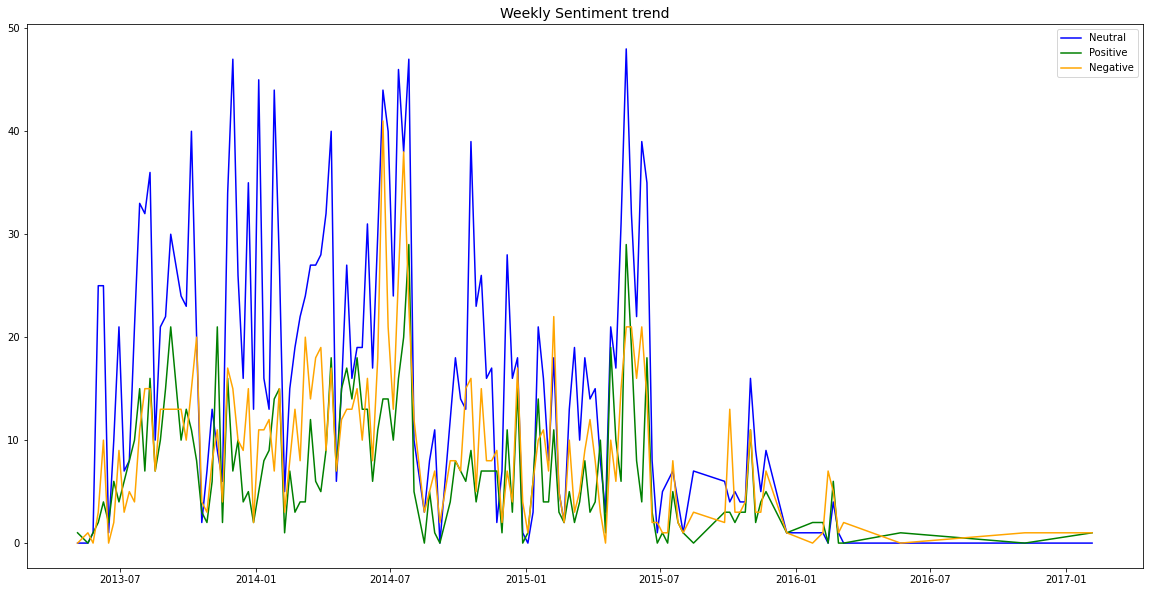

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df1.index, df1['Neutral'], color='blue', label = 'Neutral')
ax.plot(df1.index, df1['Positive'], color='green', label = 'Positive')
ax.plot(df1.index, df1['Negative'], color='orange', label = 'Negative') 
plt.title('Weekly Sentiment trend', fontsize=14)
plt.legend()
plt.show();

### 2. Anomaly detection based on trend

#### Isolation forest applied to 2 features: Ratio of positive sentiment to the total and negative sentiment to total
#### Ratio is being considered in order to take into account the total messages at any time

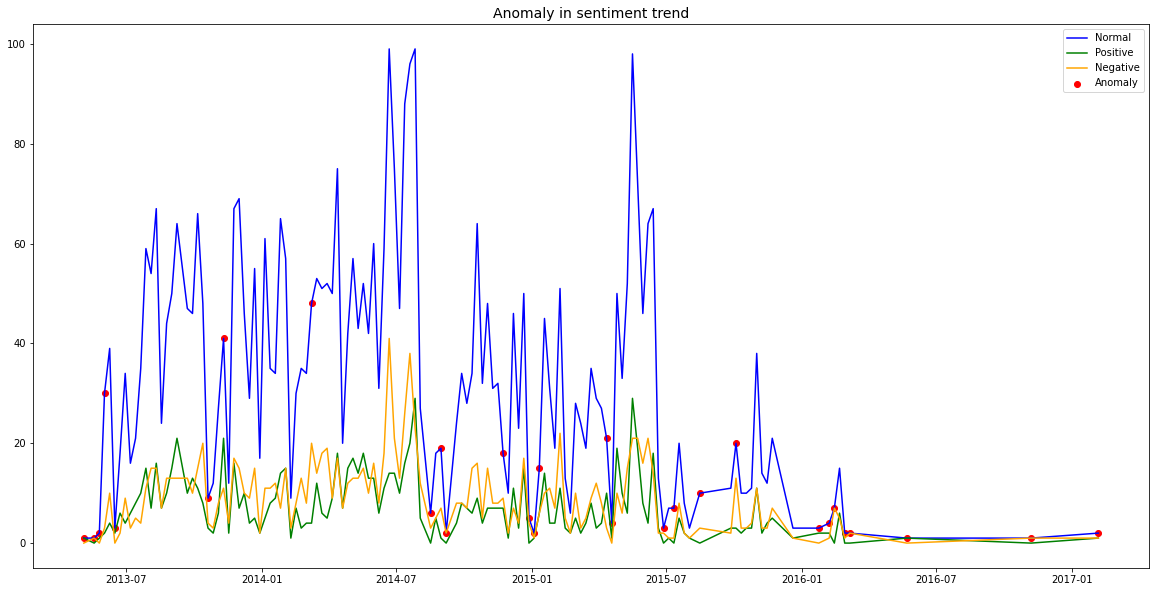

In [39]:
df1['PosR'] = df1['Positive']/df1['Total']
df1['NegR'] = df1['Negative']/df1['Total']

df1 = df1[df1['Positive']+df1['Negative']!=0]
df1['PNRatio'] = df1['Positive']/df1['Negative']


from sklearn.ensemble import IsolationForest

features = ['PosR','NegR']
clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df1[features])

pred = clf.predict(df1[features])
df1['anomaly']=pred

anomaly = df1.loc[df1['anomaly'] == -1]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df1.index, df1['Total'], color='blue', label = 'Normal')
ax.plot(df1.index, df1['Positive'], color='green', label = 'Positive')
ax.plot(df1.index, df1['Negative'], color='orange', label = 'Negative') 
ax.scatter(anomaly.index,anomaly['Total'], color='red', label = 'Anomaly')
plt.title('Anomaly in sentiment trend', fontsize=14)
plt.legend()
plt.show();


-------------------------------------

### 3. Next step is to calculate the overall sentiment score for every issue & PR

#### Study the progress in the sentiment over the lifecycle of the issue and PR
#### This will also be used as an additional feature for qualitatively analyzing the issues and PRs of every repo